In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import optuna
import itertools
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, f1_score

mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [176]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import re

In [159]:
from wordcloud import WordCloud

In [107]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [57]:
df = pd.read_csv("D:\\Projects\\SMS Spam Detection\\Data\\spam.csv", encoding="latin-1")

Data PreProcessing

In [58]:
def process_data(df):
    """
    Processes the spam CSV file to prepare it for analysis.

    This function process a CSV file containing spam messages, merges any overflow text into the main message column,
    renames columns, maps text labels to numeric values, and removes duplicate entries.

    Parameters:
    - file_path: str. The file path of the CSV file to be processed.
    - encoding: str, optional. The encoding used to read the CSV file. Defaults to 'ISO-8859-1'.

    Returns:
    - DataFrame. A pandas DataFrame containing the processed spam message data.
    """

    # Columns to merge into the 'v2' column, assuming these are overflow columns
    columns_to_merge = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]

    # Merge text function applied row-wise
    def merge_text(row):
        text_parts = [row["v2"]] + [
            row[col] for col in columns_to_merge if pd.notnull(row[col])
        ]
        merged_text = " ".join(text_parts).strip()
        return merged_text

    # Apply merge_text to each row
    df["v2"] = df.apply(merge_text, axis=1)

    # Drop the now unnecessary columns
    df = df.drop(columns=columns_to_merge)

    # Rename columns for clarity
    df.columns = ["label", "message"]

    # Map text labels to numeric values
    df["label"] = df["label"].map({"ham": 0, "spam": 1})

    # Remove duplicate rows
    df.drop_duplicates(keep="first", inplace=True)

    return df


# Example usage
# processed_df = process_data(df)
# print(processed_df.head())

In [110]:
def num_characters(df):
    """
    Adds a new column to the DataFrame containing the number of characters in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Characters"] = df["message"].apply(len)
    return df


def num_sentences(df):
    """
    Adds a new column to the DataFrame containing the number of sentences in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Sentences"] = df["message"].apply(lambda x: len(nltk.sent_tokenize(x)))
    return df


def num_words(df):
    """
    Adds a new column to the DataFrame containing the number of words in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Words"] = df["message"].apply(lambda x: len(nltk.word_tokenize(x)))
    return df

In [59]:
df = process_data(df)

In [111]:
df = num_characters(df)
df = num_sentences(df)
df = num_words(df)

In [112]:
df

,label,message,Characters,Sentences,Words
0,0,"Go until jurong point, crazy.. Available only ...",111,2,24
1,0,Ok lar... Joking wif u oni...,29,2,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,2,37
3,0,U dun say so early hor... U c already then say...,49,1,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,1,15
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,4,35
5568,0,Will Ì_ b going to esplanade fr home?,37,1,9
5569,0,"Pity, * was in mood for that. So...any other s...",57,2,15
5570,0,The guy did some bitching but I acted like i'd...,125,1,27


EDA

In [184]:
def pie_chart(df):
    """
    Creates a pie chart showing the distribution of spam and ham messages.

    Parameters:
    - df: DataFrame. The DataFrame containing the spam message data.

    Returns:
    - None.
    """

    # Get the number of spam and ham messages
    num_spam = df["label"].sum()
    num_ham = df.shape[0] - num_spam

    # Create the pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        [num_ham, num_spam],
        labels=["Ham", "Spam"],
        autopct="%1.1f%%",
        colors=["#66b3ff", "#ff9999"],
        startangle=90,
    )
    plt.title("Distribution of Spam and Ham Messages")
    plt.show()

In [188]:
def bar_chart(df):
    """
    Creates a bar chart showing the distribution of spam and ham messages.

    Parameters:
    - df: DataFrame. The DataFrame containing the spam message data.

    Returns:
    - None.
    """

    # Create the bar chart
    plt.figure(figsize=(20, 5))
    lengths = [4516, 642]
    colors = ["#66b3ff", "#ff9999"]

    # Plot horizontal bar
    plt.barh(y=0, width=sum(lengths), color="black")  # Background bar for total length
    current_position = 0
    for length, color in zip(lengths, colors):
        plt.barh(y=0, width=length, left=current_position, color=color)
        current_position += length

    # Customize appearance
    plt.yticks([])  # Hide y-axis labels
    plt.xticks([])  # Hide x-axis labels

    # Add text inside the plot
    plt.text(4516 / 2, 0, "Ham 4516", ha="center", va="center", color="black")
    plt.text(4516 + 642 / 2, 0, "Spam 642", ha="center", va="center", color="black")
    plt.title("Distribution of Ham and Spam Messages")

    plt.show()

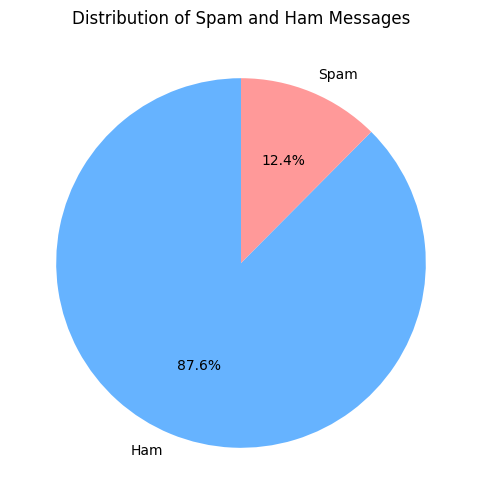

In [185]:
pie_chart(df)

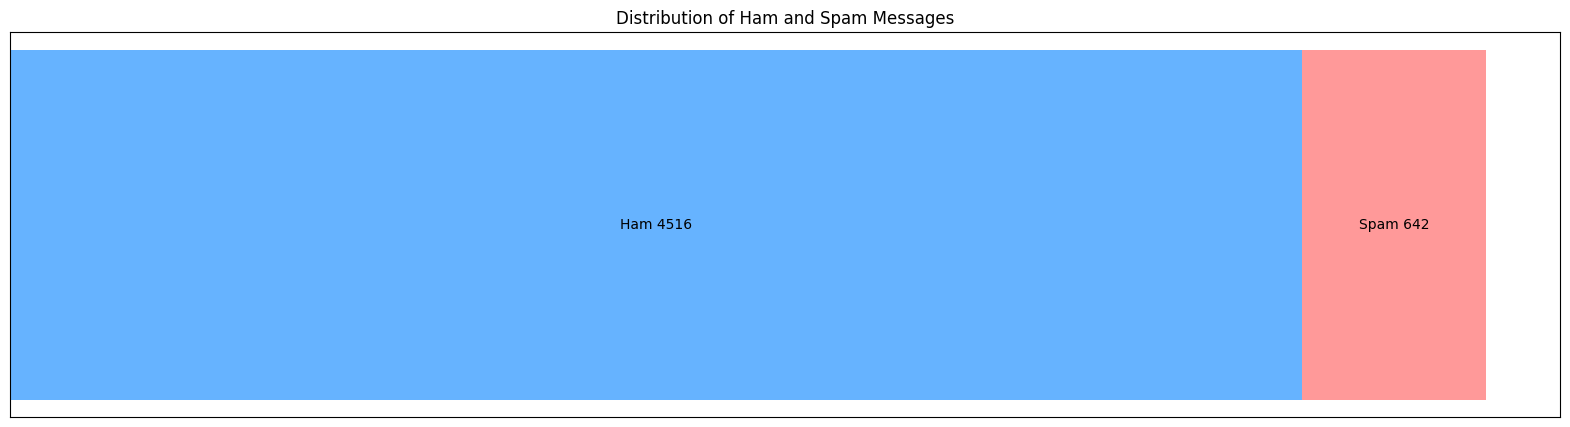

In [189]:
bar_chart(df)

In [117]:
print("Ham messages Stats:")
print(df[df["label"] == 0][["Characters", "Sentences", "Words"]].describe())
print("Spam messages Stats:")
print(df[df["label"] == 1][["Characters", "Sentences", "Words"]].describe())

Ham messages Stats:
        Characters    Sentences        Words
count  4516.000000  4516.000000  4516.000000
mean     71.024801     1.826395    17.270815
std      56.705369     1.392743    13.575169
min       2.000000     1.000000     1.000000
25%      34.000000     1.000000     8.000000
50%      53.000000     1.000000    13.000000
75%      92.000000     2.000000    22.000000
max     910.000000    38.000000   220.000000
Spam messages Stats:
       Characters   Sentences       Words
count  642.000000  642.000000  642.000000
mean   137.876947    2.968847   27.705607
std     30.075653    1.479647    7.018958
min     13.000000    1.000000    2.000000
25%    132.000000    2.000000   25.000000
50%    148.500000    3.000000   29.000000
75%    157.000000    4.000000   32.000000
max    224.000000    9.000000   46.000000


<Axes: xlabel='Characters', ylabel='Count'>

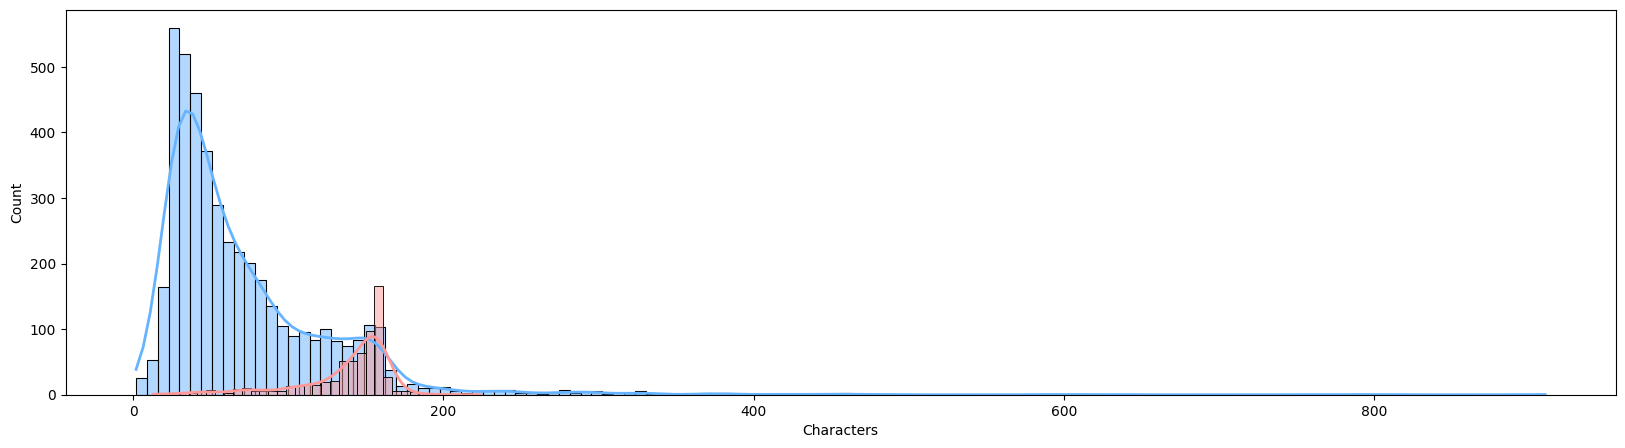

In [119]:
sns.histplot(df[df["label"] == 0]["Characters"], kde=True, color="#66b3ff", label="Ham")
sns.histplot(
    df[df["label"] == 1]["Characters"], kde=True, color="#ff9999", label="Spam"
)

<Axes: xlabel='Words', ylabel='Count'>

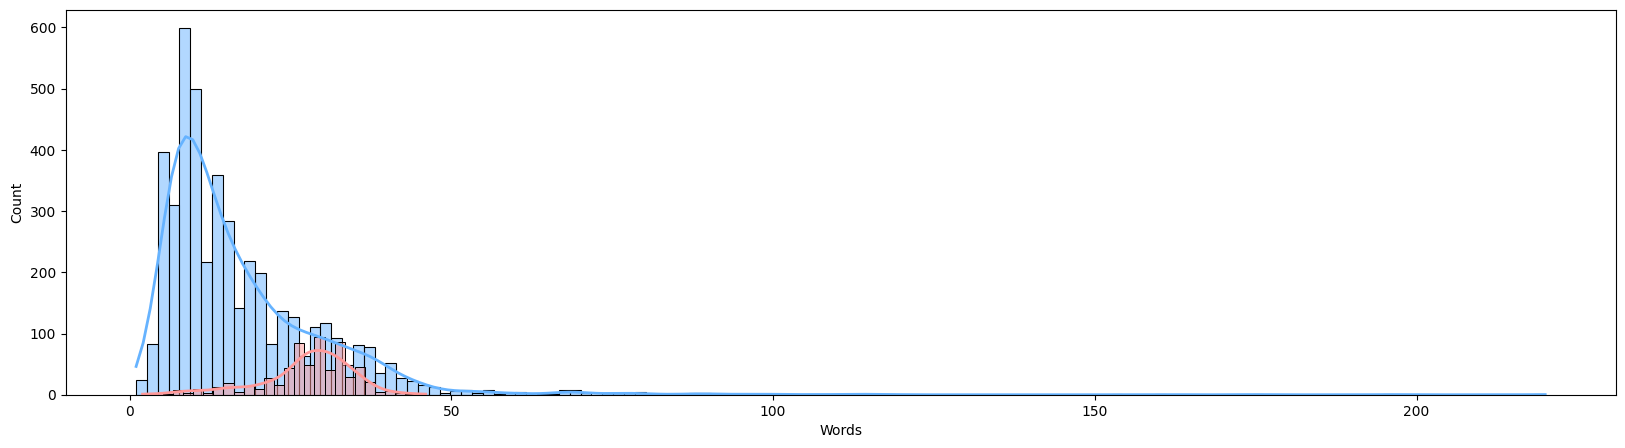

In [120]:
sns.histplot(df[df["label"] == 0]["Words"], kde=True, color="#66b3ff", label="Ham")
sns.histplot(df[df["label"] == 1]["Words"], kde=True, color="#ff9999", label="Spam")

<Axes: xlabel='Sentences', ylabel='Count'>

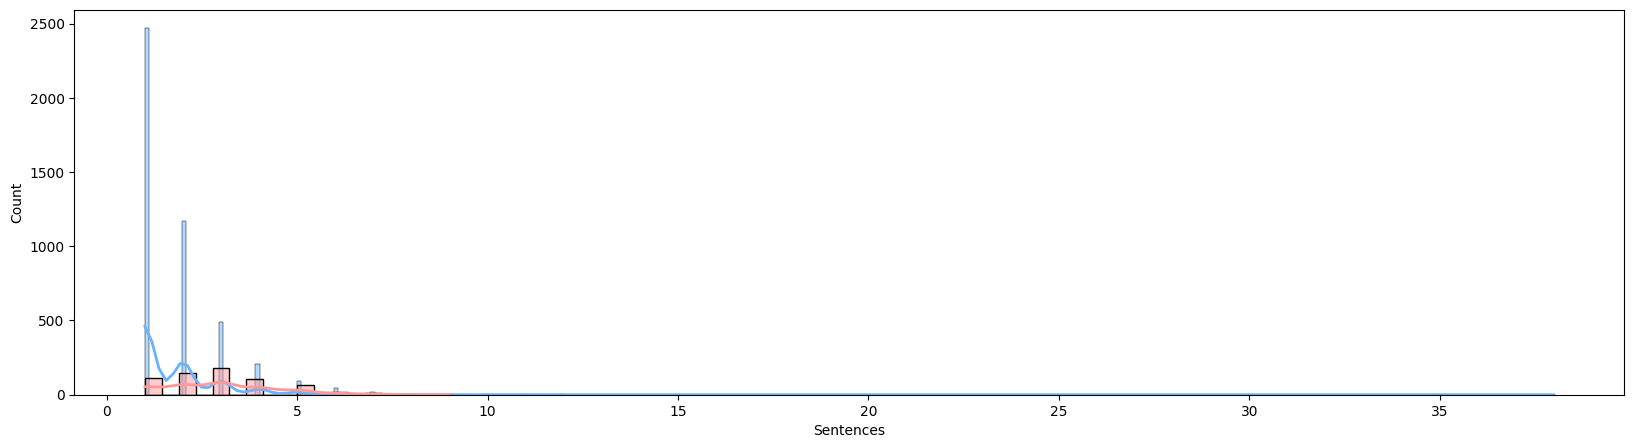

In [122]:
sns.histplot(df[df["label"] == 0]["Sentences"], kde=True, color="#66b3ff", label="Ham")
sns.histplot(df[df["label"] == 1]["Sentences"], kde=True, color="#ff9999", label="Spam")

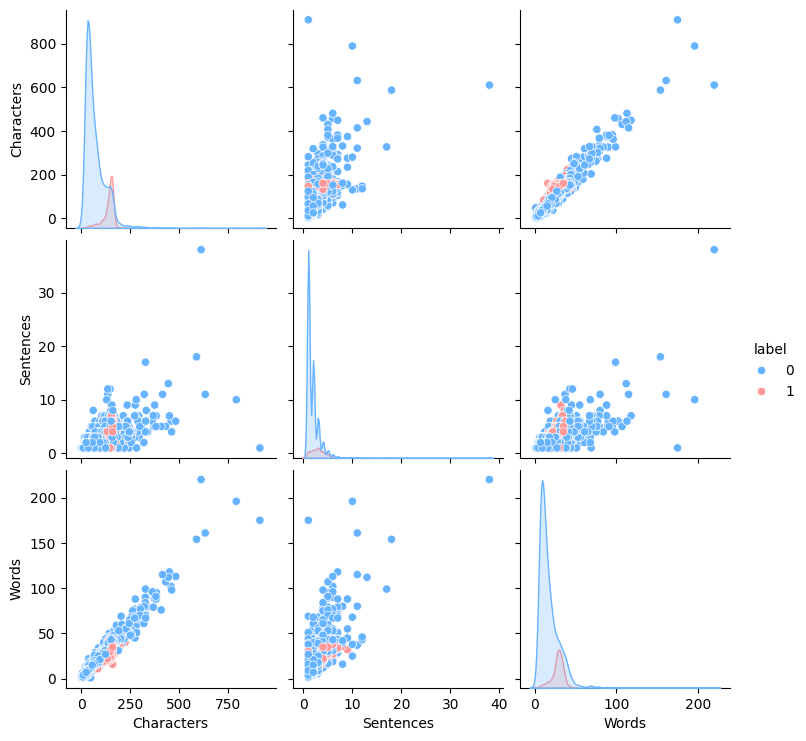

In [132]:
palette = {0: "#66b3ff", 1: "#ff9999"}
sns.pairplot(
    df[["Characters", "Sentences", "Words", "label"]], hue="label", palette=palette
)

<Axes: >

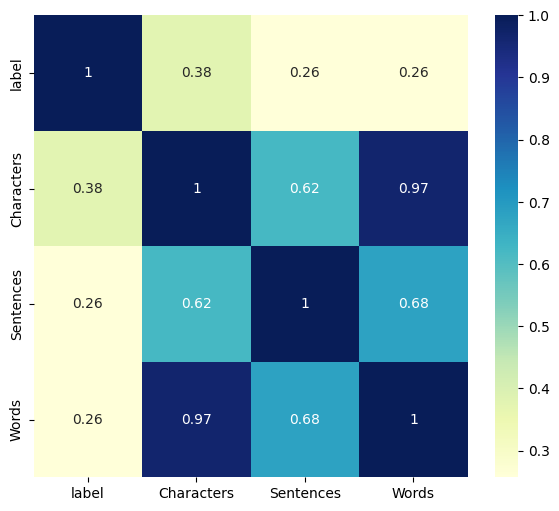

In [148]:
fig = plt.figure(figsize=(7, 6))
sns.heatmap(
    df[["label", "Characters", "Sentences", "Words"]].corr(),
    annot=True,
    cmap="YlGnBu",
)

Text PreProcessing

In [182]:
def process_text(text):
    # Convert text to lower case
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Removing special characters
    tokens = [re.sub(r"[^a-zA-Z0-9]", "", token) for token in tokens]
    tokens = [token for token in tokens if token]  # Remove empty strings

    # Removing stop words and punctuation
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens


def get_most_common_words(text_series):
    all_words = " ".join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(30)

In [155]:
df["Processed"] = df["message"].apply(process_text)

In [156]:
df

,label,message,Characters,Sentences,Words,Processed
0,0,"Go until jurong point, crazy.. Available only ...",111,2,24,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,Ok lar... Joking wif u oni...,29,2,8,"[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,2,37,"[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,49,1,13,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,1,15,"[nah, nt, think, goe, usf, live, around, though]"
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,4,35,"[2nd, time, tri, 2, contact, u, u, 750, pound,..."
5568,0,Will Ì_ b going to esplanade fr home?,37,1,9,"[b, go, esplanad, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",57,2,15,"[piti, mood, suggest]"
5570,0,The guy did some bitching but I acted like i'd...,125,1,27,"[guy, bitch, act, like, interest, buy, someth,..."


In [168]:
df["Processed"] = df["Processed"].astype(str)

In [172]:
# Verify filtering by printing samples
print("Spam samples:", df[df["label"] == 1]["Processed"].head())
print("Ham samples:", df[df["label"] == 0]["Processed"].head())

Spam samples: 2     ['free', 'entri', '2', 'wkli', 'comp', 'win', ...
5     ['freemsg', 'hey', 'darl', '3', 'week', 'word'...
8     ['winner', 'valu', 'network', 'custom', 'selec...
9     ['mobil', '11', 'month', 'u', 'r', 'entitl', '...
11    ['six', 'chanc', 'win', 'cash', '100', '20000'...
Name: Processed, dtype: object
Ham samples: 0    ['go', 'jurong', 'point', 'crazi', 'avail', 'b...
1             ['ok', 'lar', 'joke', 'wif', 'u', 'oni']
3    ['u', 'dun', 'say', 'earli', 'hor', 'u', 'c', ...
4    ['nah', 'nt', 'think', 'goe', 'usf', 'live', '...
6    ['even', 'brother', 'like', 'speak', 'treat', ...
Name: Processed, dtype: object


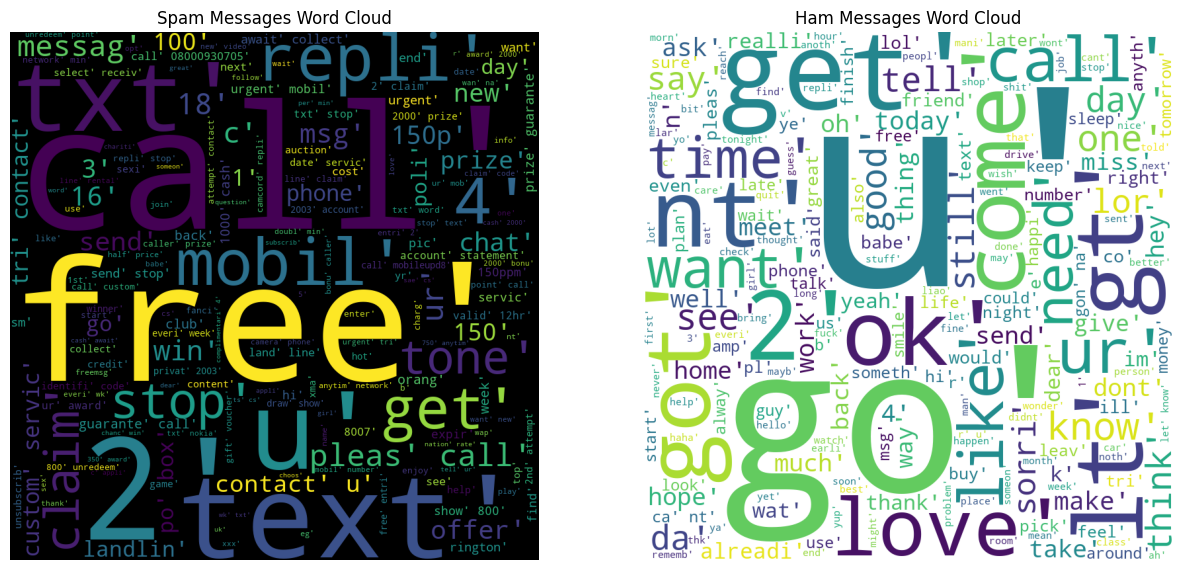

In [174]:
spam_text = df[df["label"] == 1]["Processed"].astype(str).str.cat(sep=" ")
ham_text = df[df["label"] == 0]["Processed"].astype(str).str.cat(sep=" ")

spam_wc = WordCloud(
    width=800, height=800, background_color="black", stopwords=None, min_font_size=10
).generate(spam_text)

ham_wc = WordCloud(
    width=800, height=800, background_color="white", stopwords=None, min_font_size=10
).generate(ham_text)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(spam_wc)
plt.title("Spam Messages Word Cloud")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(ham_wc)
plt.title("Ham Messages Word Cloud")
plt.axis("off")
plt.show()

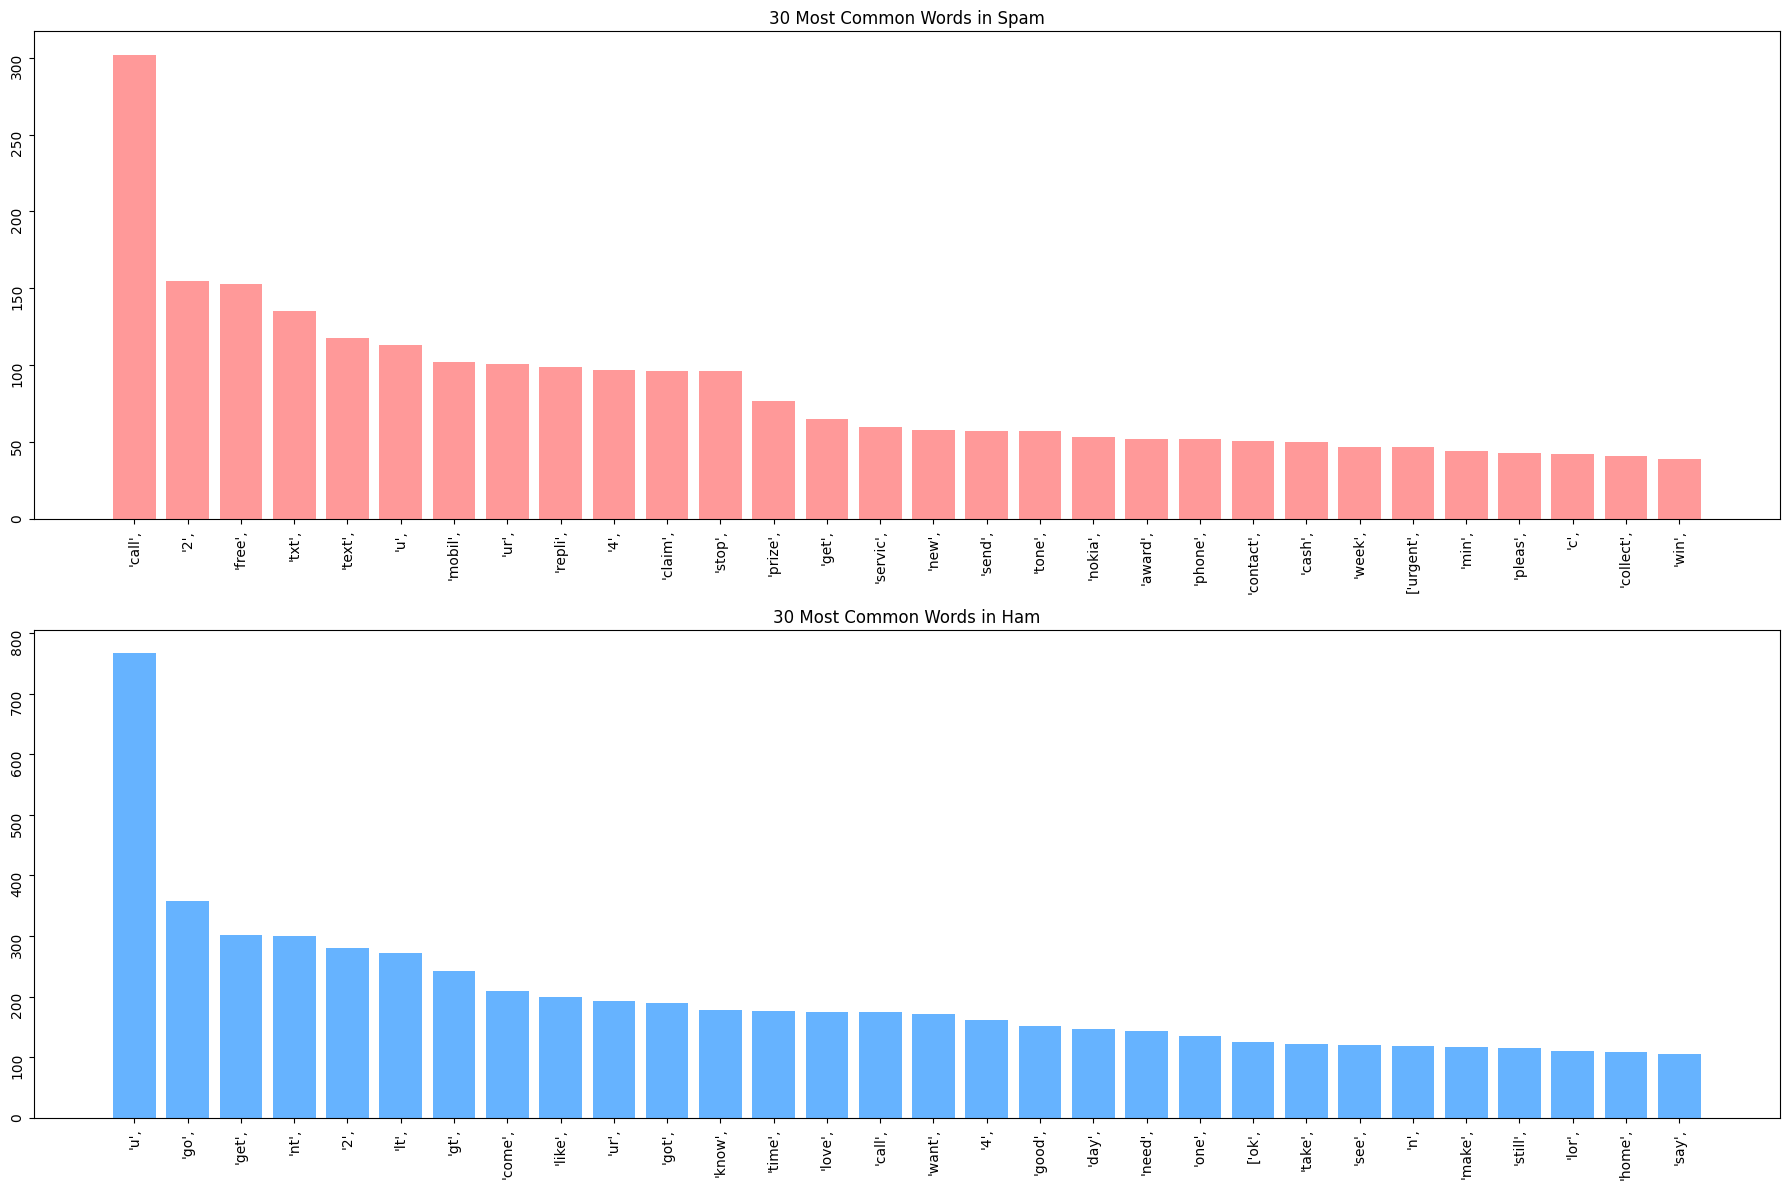

In [183]:
spam_df = df[df["label"] == 1]
ham_df = df[df["label"] == 0]

spam_common_words = get_most_common_words(spam_df["Processed"])
ham_common_words = get_most_common_words(ham_df["Processed"])

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

spam_words, spam_counts = zip(*spam_common_words)
axes[0].bar(spam_words, spam_counts, color="#ff9999")
axes[0].set_title("30 Most Common Words in Spam")
axes[0].tick_params(labelrotation=90)

ham_words, ham_counts = zip(*ham_common_words)
axes[1].bar(ham_words, ham_counts, color="#66b3ff")
axes[1].set_title("30 Most Common Words in Ham")
axes[1].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

Model Building

In [214]:
def objective_gnb(trial):
    var_smoothing = trial.suggest_float("var_smoothing", 1e-10, 1e-8)
    model = GaussianNB(var_smoothing=var_smoothing)
    return cross_val_score(model, X, y, scoring=make_scorer(f1_score), cv=5).mean()


def objective_mnb(trial):
    alpha = trial.suggest_float("alpha", 0.0, 1.0)
    fit_prior = trial.suggest_categorical("fit_prior", [True, False])
    model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    return cross_val_score(model, X, y, scoring=make_scorer(f1_score), cv=5).mean()


def objective_bnb(trial):
    alpha = trial.suggest_float("alpha", 0.0, 1.0)
    binarize = trial.suggest_float("binarize", 0.0, 1.0)
    fit_prior = trial.suggest_categorical("fit_prior", [True, False])
    model = BernoulliNB(alpha=alpha, binarize=binarize, fit_prior=fit_prior)
    return cross_val_score(model, X, y, scoring=make_scorer(f1_score), cv=5).mean()


def print_evaluation_metrics(model_name, y_test, y_pred, classes):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(
        confusion, classes, title="Confusion matrix for " + model_name
    )

    print(f"{model_name} Evaluation Metrics:")
    print(f"Accuracy Score: {accuracy:.4f}")
    print(f"Precision Score: {precision:.4f}")
    print("Confusion Matrix:")
    print(confusion)
    print("\n")


def plot_confusion_matrix(cm, classes, title="Confusion matrix"):
    """
    This function prints and plots the confusion matrix.
    :param cm: Confusion Matrix
    :param classes: List of class names
    :param title: Title for the plot
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.grid(False)
    plt.show()

In [191]:
tfidf = TfidfVectorizer(max_features=3000)

In [192]:
X = tfidf.fit_transform(df["Processed"].astype(str)).toarray()

In [216]:
characters = df["Characters"].values
X2 = np.column_stack((X, characters))

In [194]:
y = df["label"].values

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [217]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.2, random_state=2
)

In [198]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [203]:
study_gnb = optuna.create_study(direction="maximize")
study_gnb.optimize(objective_gnb, n_trials=100)

study_mnb = optuna.create_study(direction="maximize")
study_mnb.optimize(objective_mnb, n_trials=100)

study_bnb = optuna.create_study(direction="maximize")
study_bnb.optimize(objective_bnb, n_trials=100)

print("Best parameters for GaussianNB:", study_gnb.best_params)
print("Best parameters for MultinomialNB:", study_mnb.best_params)
print("Best parameters for BernoulliNB:", study_bnb.best_params)

[I 2024-03-19 05:13:27,735] A new study created in memory with name: no-name-e4a4b414-595e-4e1c-bf92-dc5f94ff108e
[I 2024-03-19 05:13:31,050] Trial 0 finished with value: 0.6198574552550887 and parameters: {'var_smoothing': 8.198161157119768e-09}. Best is trial 0 with value: 0.6198574552550887.
[I 2024-03-19 05:13:33,362] Trial 1 finished with value: 0.6198574552550887 and parameters: {'var_smoothing': 6.77095609530097e-10}. Best is trial 0 with value: 0.6198574552550887.
[I 2024-03-19 05:13:35,930] Trial 2 finished with value: 0.6198574552550887 and parameters: {'var_smoothing': 1.2337050376725916e-09}. Best is trial 0 with value: 0.6198574552550887.
[I 2024-03-19 05:13:38,295] Trial 3 finished with value: 0.6198574552550887 and parameters: {'var_smoothing': 6.492428793524777e-09}. Best is trial 0 with value: 0.6198574552550887.
[I 2024-03-19 05:13:40,811] Trial 4 finished with value: 0.6198574552550887 and parameters: {'var_smoothing': 3.467559666070103e-09}. Best is trial 0 with val

Best parameters for GaussianNB: {'var_smoothing': 8.198161157119768e-09}
Best parameters for MultinomialNB: {'alpha': 0.04923341709064957, 'fit_prior': True}
Best parameters for BernoulliNB: {'alpha': 0.20289957399493277, 'binarize': 0.13491256940819382, 'fit_prior': False}


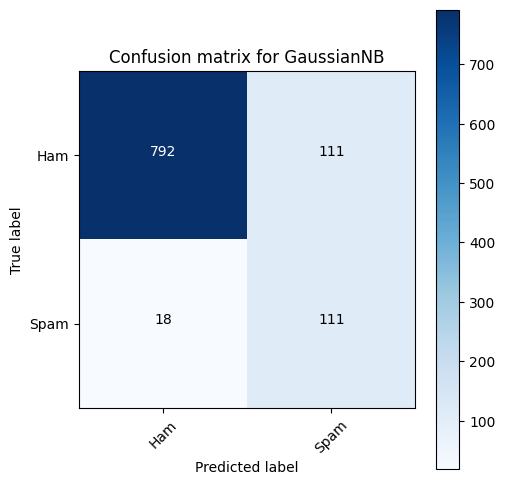

GaussianNB Evaluation Metrics:
Accuracy Score: 0.8750
Precision Score: 0.5000
Confusion Matrix:
[[792 111]
 [ 18 111]]




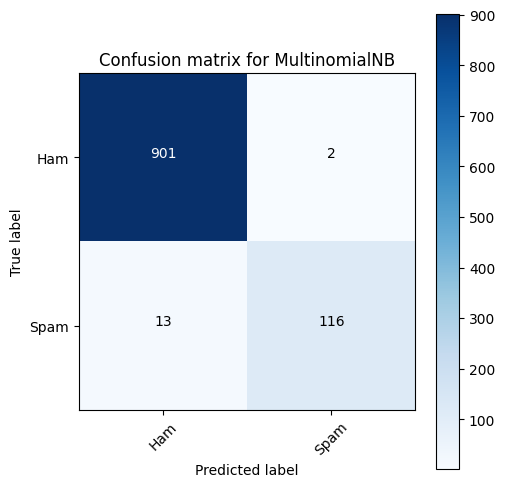

MultinomialNB Evaluation Metrics:
Accuracy Score: 0.9855
Precision Score: 0.9831
Confusion Matrix:
[[901   2]
 [ 13 116]]




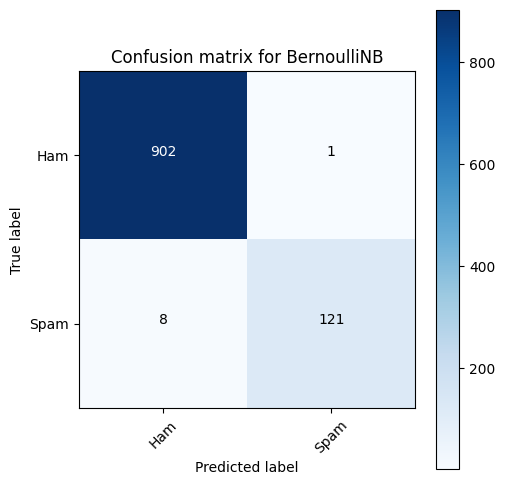

BernoulliNB Evaluation Metrics:
Accuracy Score: 0.9913
Precision Score: 0.9918
Confusion Matrix:
[[902   1]
 [  8 121]]




In [222]:
gnb_best_params = study_gnb.best_params
gnb_model = GaussianNB(var_smoothing=gnb_best_params["var_smoothing"])
gnb_model.fit(X_train, y_train)

mnb_best_params = study_mnb.best_params
mnb_model = MultinomialNB(
    alpha=mnb_best_params["alpha"], fit_prior=mnb_best_params["fit_prior"]
)
mnb_model.fit(X_train, y_train)

bnb_best_params = study_bnb.best_params
bnb_model = BernoulliNB(
    alpha=bnb_best_params["alpha"],
    binarize=bnb_best_params["binarize"],
    fit_prior=bnb_best_params["fit_prior"],
)
bnb_model.fit(X_train, y_train)

y_pred_gnb = gnb_model.predict(X_test)
y_pred_mnb = mnb_model.predict(X_test)
y_pred_bnb = bnb_model.predict(X_test)
classes = ["Ham", "Spam"]
print_evaluation_metrics("GaussianNB", y_test, y_pred_gnb, classes)
print_evaluation_metrics("MultinomialNB", y_test, y_pred_mnb, classes)
print_evaluation_metrics("BernoulliNB", y_test, y_pred_bnb, classes)

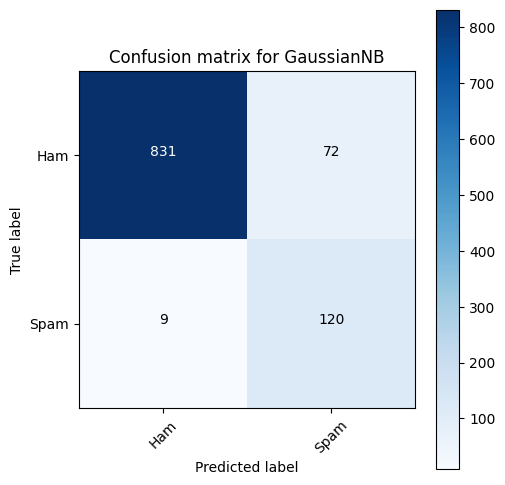

GaussianNB Evaluation Metrics:
Accuracy Score: 0.9215
Precision Score: 0.6250
Confusion Matrix:
[[831  72]
 [  9 120]]




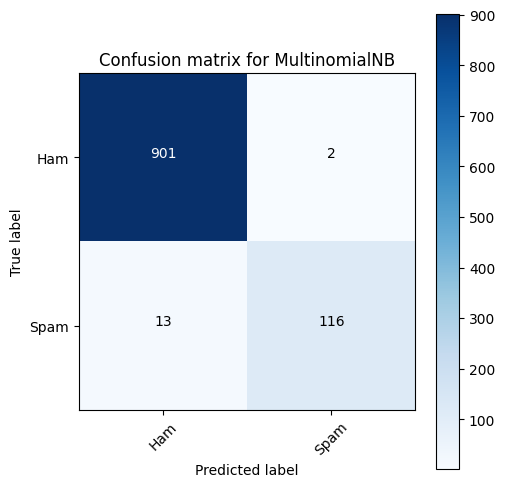

MultinomialNB Evaluation Metrics:
Accuracy Score: 0.9855
Precision Score: 0.9831
Confusion Matrix:
[[901   2]
 [ 13 116]]




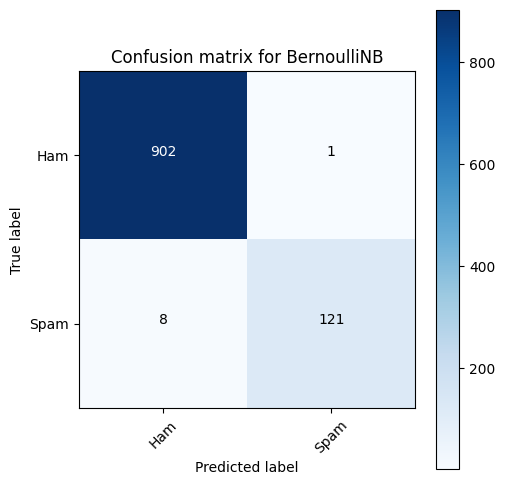

BernoulliNB Evaluation Metrics:
Accuracy Score: 0.9913
Precision Score: 0.9918
Confusion Matrix:
[[902   1]
 [  8 121]]




In [221]:
gnb_best_params = study_gnb.best_params
gnb_model = GaussianNB(var_smoothing=gnb_best_params["var_smoothing"])
gnb_model.fit(X2_train, y2_train)

mnb_best_params = study_mnb.best_params
mnb_model = MultinomialNB(
    alpha=mnb_best_params["alpha"], fit_prior=mnb_best_params["fit_prior"]
)
mnb_model.fit(X2_train, y2_train)

bnb_best_params = study_bnb.best_params
bnb_model = BernoulliNB(
    alpha=bnb_best_params["alpha"],
    binarize=bnb_best_params["binarize"],
    fit_prior=bnb_best_params["fit_prior"],
)
bnb_model.fit(X2_train, y2_train)

y2_pred_gnb = gnb_model.predict(X2_test)
y2_pred_mnb = mnb_model.predict(X2_test)
y2_pred_bnb = bnb_model.predict(X2_test)
classes = ["Ham", "Spam"]
print_evaluation_metrics("GaussianNB", y2_test, y2_pred_gnb, classes)
print_evaluation_metrics("MultinomialNB", y2_test, y2_pred_mnb, classes)
print_evaluation_metrics("BernoulliNB", y2_test, y2_pred_bnb, classes)

In [225]:
pickle.dump(tfidf, open("vectorizer.pkl", "wb"))
pickle.dump(mnb_model, open("mnb_model.pkl", "wb"))
pickle.dump(gnb_model, open("gnb_model.pkl", "wb"))
pickle.dump(bnb_model, open("bnb_model.pkl", "wb"))